Assignment on Graph Neural Networks in the course Advanced machine learning using neural networks (Chalmers and University of Gothenburg).

The objective is to train a GNN that works as a graph classifier on the provided data. The data comes from simulations of a 25 qubit quantum memory (surface code) with individual error rates of 5% per cycle of measurements (see assignment text for a little more detail). Since the data consists of graphs with varying number of nodes the way to implement the classifier is to make a graph embedding, i.e. a mapping of each graph to a vector of fixed size. This can then be used for classification. The typical structure would be Graph data-> Graph (convolution or other) layers -> Pooling -> Dense classifier.

For this data the classification accuracy of the standard graph algorithm based decoder (minimum weight perfect matching) is 0.983. It may be hard to reach this without an even larger dataset, but it can serve as a target. Anything above an accuracy of 0.95 is acceptable. (This means that the quantum memory has a lower failure rate than the individual qubits, which is set at 5% to generate the data.)

In [ ]:
#This takes a while
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.6/107.6 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.2/209.2 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 160, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 241, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 463, in run
    _, build_failures = build(
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/wheel_builder.py", line 347, in build
    wheel_file = _build_one(
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/wheel_builder.py", line 221, in _build_one
    wheel_path = _build_one_insid

Some suggested GNN layers, you're welcome to try other.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch_geometric
from torch_geometric.loader import DataLoader
import torch_geometric.utils as utils
import networkx as nx
from torch.nn import Linear, Sequential, BatchNorm1d, ReLU, Dropout
from torch_geometric.nn import global_mean_pool, global_add_pool, GraphConv, GATConv, GCNConv, GINConv
import torch.nn.functional as F

%config InlineBackend.figure_format = 'svg'

The following shows how to load the data if it's available in your Google drive

In [ ]:
#If the data is available in your Google drive:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#It's a quite big dataset, so may take a few minutes
dataset = torch.load('/content/drive/MyDrive/graph_data_decoding_2023.pt')

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Properties of the graphs

In [ ]:
print('====================')
print(f'Number of graphs: {len(dataset)}')
print('=============================================================')
data = dataset[2]  # Get one data point.

print('Some properties of a graph in the dataset:')

print(data)
# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')
print(f'Number of node features: {data.num_node_features}')



Number of graphs: 1000000
Some properties of a graph in the dataset:
Data(x=[3, 4], edge_index=[2, 6], edge_attr=[6, 1], y=[1, 2])
Number of nodes: 3
Number of edges: 6
Average node degree: 2.00
Has isolated nodes: False
Has self-loops: False
Is undirected: True
Number of node features: 4


Note that the label y, is given by a tensor with 2 elements, giving a binary representation of the predicted equivalence class.

*   00 <-> class I
*   10 <-> class X
*   01 <-> class Z
*   11 <-> class Y

The loss can either be constructed using two spearate classifiers, one for X and one for Z, or combined into one over all four classes. Either should work.



In [ ]:
label=data.y
label_X=label[:,0]
label_Z=label[:,1]
print(label_X,label_Z)
#The data point dataset[20] is thus in class X

tensor([1.]) tensor([0.])


The data consists of 4-dimensional feature vector per node, and each edge comes with a scalar weight.

In [ ]:
edge_index = data.edge_index.t()
edge_index=edge_index.numpy()
feature=data.x.numpy()
edge=data.edge_attr.numpy()
print(edge_index)
print(edge)
print(feature)

[[0 1]
 [0 2]
 [1 0]
 [1 2]
 [2 0]
 [2 1]]
[[0.11111111]
 [0.25      ]
 [0.11111111]
 [1.        ]
 [0.25      ]
 [1.        ]]
[[0.  1.  0.2 0.4]
 [0.  1.  0.4 1. ]
 [0.  1.  0.6 0.8]]


In [ ]:
graph = dataset[2]
g = utils.to_networkx(graph, to_undirected=True)
positions = {}
label_positions = {}
node_labels = {}
edge_labels={}
x = graph.x
for i in range(x.shape[0]):
    positions[i] = np.array([x[i, 2], x[i, 3]])
    label_positions[i] = np.array([x[i, 2], x[i, 3]])
    node_labels[i] = np.array([x[i, 0], x[i, 1], x[i, 2], x[i, 3]])
for i in range(edge_index.shape[0]):
    edge_labels[(edge_index[i,0],edge_index[i,1])]=edge[i]

(0.15799999997019767,
 0.6420000268518924,
 0.3370000049471855,
 1.063000001013279)

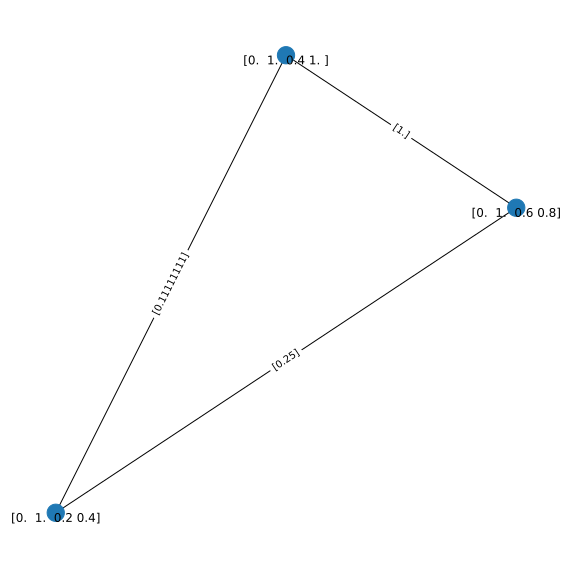

In [ ]:
fig, ax = plt.subplots(figsize = (10, 10))
nx.draw_networkx(g, ax=ax, pos = positions, labels = node_labels, with_labels = False)
nx.draw_networkx_labels(g, ax=ax, pos = label_positions, labels = node_labels, verticalalignment= 'top')
nx.draw_networkx_edge_labels(g,ax=ax,  pos = positions,edge_labels=edge_labels)
ax.axis('off')

In [ ]:
# split the dataset into test and validation:
batch_size = 1000
num_samples = len(dataset)
train_data = dataset[int(.05 * num_samples ) :] # 95% train
test_data = dataset[: int(.05 * num_samples )] # 5% test
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

Construct you network. Train and test.

In [ ]:
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        torch.manual_seed(12345)

        num_classes = 4

        self.conv1 = GraphConv(data.num_node_features, 4*data.num_node_features)
        self.conv2 = GraphConv(4*data.num_node_features,16*data.num_node_features)
        self.conv3 = GraphConv(16*data.num_node_features, 4*data.num_node_features)
        self.conv4 = GraphConv(4*data.num_node_features, data.num_node_features)

        self.linear1 = Linear(data.num_node_features, num_classes)

    def forward(self, x, edge_index, edge_attr, batch):
        x = self.conv1(x, edge_index, edge_weight=edge_attr) # graph_weights=graph_attribute, more layers
        x = x.relu()
        x = self.conv2(x, edge_index, edge_weight=edge_attr)
        x = x.relu()
        x = self.conv3(x, edge_index, edge_weight=edge_attr)
        x = x.relu()
        x = self.conv4(x, edge_index, edge_weight=edge_attr)

        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        x = F.dropout(x, p=0.5, training=self.training)
        x = self.linear1(x)

        return x

model = GCN()
print(model)

GCN(
  (conv1): GraphConv(4, 16)
  (conv2): GraphConv(16, 64)
  (conv3): GraphConv(64, 16)
  (conv4): GraphConv(16, 4)
  (linear1): Linear(in_features=4, out_features=4, bias=True)
)


In [ ]:
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GCN()

optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    batch_count = 0
    for batch in train_loader:  # Iterate in batches over the training dataset.
        out = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch)  # Perform a single forward pass.

        optimizer.zero_grad()  # Clear gradients.

        y_tensor = batch.y
        y_dec = []
        for y in y_tensor:
            y_str = str(int(y[0])) + str(int(y[1]))
            y_int = int(y_str, 2)
            y_dec.append(y_int)
        y = torch.tensor(y_dec)

        loss = criterion(out, y)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.

        batch_count += 1
        if batch_count % 100 == 0:
            print(batch_count, " / ", len(train_loader))

<IPython.core.display.Javascript object>

In [ ]:
def test(loader):
    model.eval()

    correct_tot = 0
    loss_tot = 0

    for batch in loader:
        out = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch)

        y_tensor = batch.y
        y_dec = []
        for y in y_tensor:
            y_str = str(int(y[0])) + str(int(y[1]))
            y_int = int(y_str, 2)
            y_dec.append(y_int)
        y = torch.tensor(y_dec)

        loss = criterion(out, y)
        loss_tot += loss.item()
        pred = out.argmax(dim=1)
        correct_tot += int((pred == y).sum())

    test_acc_avg = correct_tot / len(loader.dataset)
    test_loss_avg = loss_tot / len(loader.dataset)

    return  test_acc_avg, test_loss_avg

In [ ]:
n_epochs = 20
batch_size = 1000
n_batches = len(train_loader) #950

train_acc_list = []
test_acc_list = []
epoch_list = []

for epoch in range(n_epochs):
    train()
    train_acc, train_loss = test(train_loader)
    test_acc, test_loss = test(test_loader)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    epoch_list.append(epoch+1)
    print("Epoch: ", epoch+1, "Training accuracy: ",train_acc,  "Test accuracy: ", test_acc, "Training loss: ", train_loss, "Test loss: ", test_loss)

100  /  950
200  /  950
300  /  950
400  /  950
500  /  950
600  /  950
700  /  950
800  /  950
900  /  950
Epoch:  1 Training accuracy:  0.9431715789473685 Test accuracy:  0.94282 Training loss:  0.00017773792320176175 Test loss:  0.0001787885782122612
100  /  950
200  /  950
300  /  950
400  /  950
500  /  950
600  /  950
700  /  950
800  /  950
900  /  950
Epoch:  2 Training accuracy:  0.9521231578947369 Test accuracy:  0.95106 Training loss:  0.00014533471251004622 Test loss:  0.00014588059589266776
100  /  950
200  /  950
300  /  950
400  /  950
500  /  950
600  /  950
700  /  950
800  /  950
900  /  950
Epoch:  3 Training accuracy:  0.9560115789473684 Test accuracy:  0.95514 Training loss:  0.00013065697568027596 Test loss:  0.0001321082864701748
100  /  950
200  /  950
300  /  950
400  /  950
500  /  950
600  /  950
700  /  950
800  /  950
900  /  950
Epoch:  4 Training accuracy:  0.9585673684210526 Test accuracy:  0.95672 Training loss:  0.0001262239509271948 Test loss:  0.0001

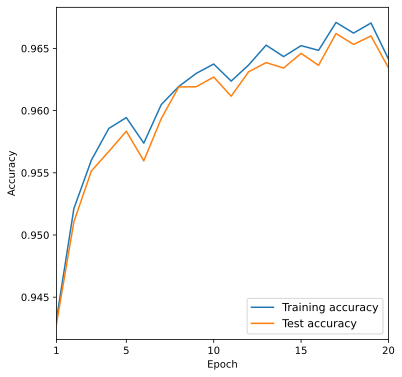

In [ ]:
figsize = 6
location = r'/content/drive/MyDrive/Skola/CAS/Advanced Machine Learning/HW A'
title = '/A(E)_3'

fig, ax = plt.subplots(figsize=(figsize,figsize))
ax.plot(epoch_list, train_acc_list, label='Training accuracy')
ax.plot(epoch_list, test_acc_list, label='Test accuracy')
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")
ax.set_box_aspect(1)
ax.set_xlim([1,epoch_list[-1]])
ax.set_xticks([1, 5, 10, 15, 20])
ax.legend(loc="lower right", prop={'size': 11})
# plt.savefig(location+title+'.png')
plt.show()